# North Pole Analytics DEMO

##### You can use any tool for analytics, but Python is a good place to start as it is free and easy to learn
Python is an interpreted, object-oriented, high-level programming language with dynamic semantics.

Important points:
- object oriented - tries to model code as "objects"
- high-level - closer to english language
- dynamic semantics - the language is not strict

### Load relevant modules
Python Libraries are a set of useful functions that eliminate the need for writing codes from scratch.

In [1]:
# quantitative functions and data structures
import numpy as np
import scipy as spy
import pandas as pd

# shapes, geolocation, and network functions and data structures
from shapely.geometry import Point
import shapely
import geopandas as gpd
import networkx as ntx
from scipy.spatial.distance import cdist

# machine learning
from sklearn.cluster import KMeans

# visualization 
import matplotlib.pyplot as plt
import mplleaflet


### Data Preparation & Exploration

##### What is Pandas?
Pandas is a software library written for the Python programming language for data manipulation and analysis.

In [2]:
gifts_df = pd.read_csv("data/gifts.csv")
gifts_df.head()

,GiftId,Latitude,Longitude,Weight
0,1,16.345769,6.303545,1.000000
1,2,12.494749,28.626396,15.524480
2,3,27.794615,60.032495,8.058499
3,4,44.426992,110.114216,1.000000
4,5,-69.854088,87.946878,25.088892


How many gifts are going to be sent out

In [3]:
gifts_df.shape

(100000, 4)

Let's convert our pandas dataframe into a geopandas dataframe 

In [4]:
gdf = gpd.GeoDataFrame(
    gifts_df.drop(['Latitude', 'Longitude'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(gifts_df.Longitude, gifts_df.Latitude)])

gdf.head()

,GiftId,Weight,geometry
0,1,1.000000,POINT (6.30355 16.34577)
1,2,15.524480,POINT (28.62640 12.49475)
2,3,8.058499,POINT (60.03249 27.79462)
3,4,1.000000,POINT (110.11422 44.42699)
4,5,25.088892,POINT (87.94688 -69.85409)


Let's plot this information and see what it looks like

##### Matplotlib is a plotting library for the Python programming language
Pandas and Geopandas uses Matplotlib for plotting / visualizing data

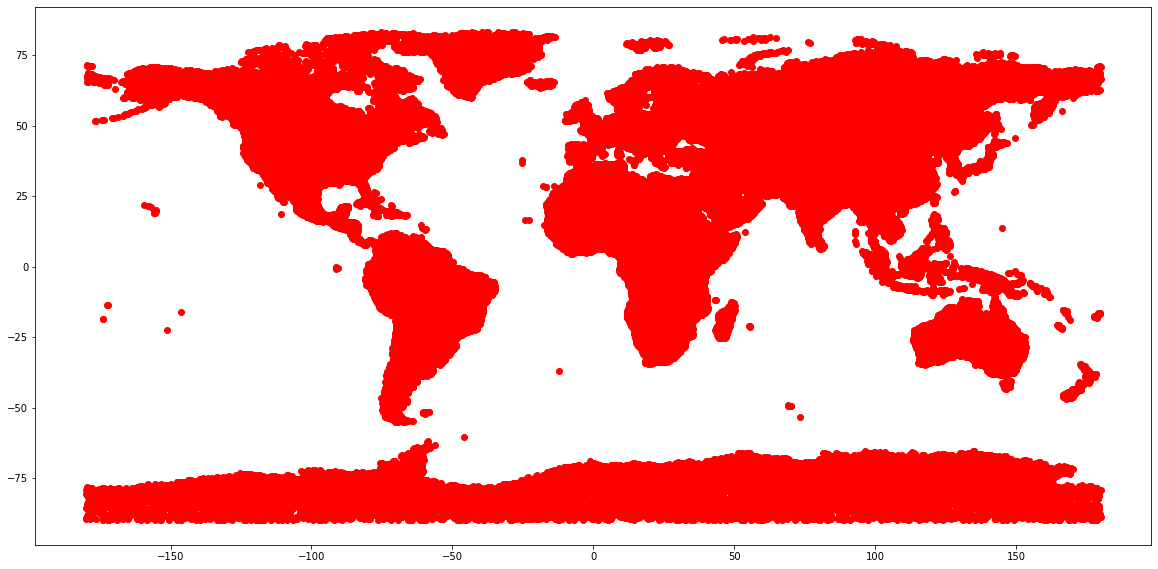

In [5]:
gdf.plot( color='red',figsize=(20, 15))

##### Natural Earth Dataset
- https://www.naturalearthdata.com/
- Pop and gdp info are late 2010 estimates

Let's connect the points with real world information so it's more understandable for us

In [6]:
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


And now let's do a join on our dataset. Geopandas helps by 'joining' based on geo coordinates

In [7]:
world_gifts_df = gpd.tools.sjoin(gdf, world_df, how='inner')
world_gifts_df.head()

,GiftId,Weight,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
0,1,1.000000,POINT (6.30355 16.34577),55,19245344,Africa,Niger,NER,20150.0
178,179,40.333787,POINT (8.54290 21.52880),55,19245344,Africa,Niger,NER,20150.0
425,426,8.182597,POINT (4.35877 18.44012),55,19245344,Africa,Niger,NER,20150.0
451,452,37.434888,POINT (4.87445 17.57498),55,19245344,Africa,Niger,NER,20150.0
758,759,1.000000,POINT (10.34569 19.37971),55,19245344,Africa,Niger,NER,20150.0


It looks like there were a few thousands that could not be connected to our countries / continents data.

In [8]:
world_gifts_df.shape

(97517, 9)

How does the gift distribution look like per continent?

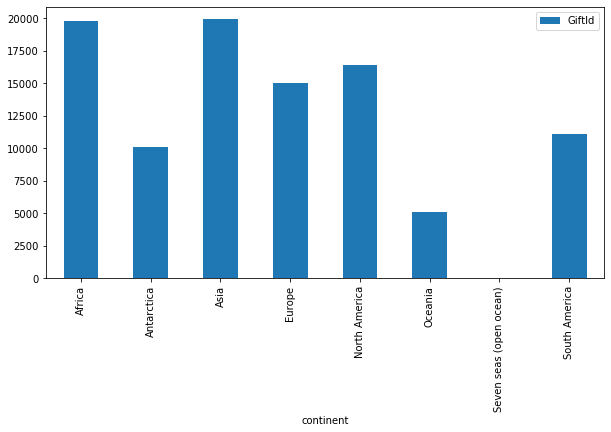

In [9]:
pd.pivot_table(world_gifts_df,values='GiftId',index=['continent'],aggfunc=pd.Series.nunique).plot(kind='bar',figsize=(10, 5))

Let's check how many gifts will be sent per country compared to estimated children. Does it make sense?

##### The average amount of kids for 2020 based on 186 countries was 27.09 percent.
Population ages 0-14, percent of total, 2020. The highest value was in Niger: 49.67 percent and the lowest value was in Singapore: 12.3 percent. The indicator is available from 1960 to 2020.

https://www.theglobaleconomy.com/rankings/percent_children/#:~:text=The%20average%20for%202020%20based,available%20from%201960%20to%202020.

In [10]:
world_gifts_df['pop_children_est'] = round(world_gifts_df['pop_est']  * .2709,0)
world_gifts_df['pop_children_est'] = world_gifts_df['pop_children_est'].astype(int)

In [11]:
pd.pivot_table(world_gifts_df,values='GiftId',index=['name','pop_est','pop_children_est'],aggfunc=pd.Series.nunique)

,,,GiftId
name,pop_est,pop_children_est,
Afghanistan,34124811,9244411,415
Albania,3047987,825700,10
Algeria,40969443,11098622,1614
Angola,29310273,7940153,859
Antarctica,4050,1097,10108
...,...,...,...
W. Sahara,603253,163421,75
Yemen,28036829,7595177,285
Zambia,15972000,4326815,493


In [12]:
world_gifts_df['Weight'].mean()

14.102086626823926

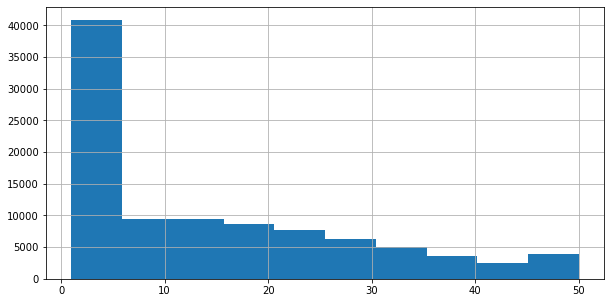

In [13]:
world_gifts_df['Weight'].hist(figsize=(10,5))

- Looks like most gifts don't weigh a lot but might have load implications for delivery.
- What about quality? since we don't have a quality metric to compare to, we'll hold that question for now.

###  Is there a way for us to estimate the best way to divide this coverage?
A K-means clustering algorithm tries to group similar items in the form of clusters. The number of groups is represented by K.
![](https://miro.medium.com/max/1200/1*rw8IUza1dbffBhiA4i0GNQ.png)

convert longitudes and latitudes into x,y matrix for clustering

In [14]:
world_a=pd.Series(world_gifts_df['geometry'].apply(lambda p: p.x))
world_b=pd.Series(world_gifts_df['geometry'].apply(lambda p: p.y))
world_X=np.column_stack((world_a,world_b))

pd.DataFrame(world_X).head()

,0,1
0,6.303545,16.345769
1,8.542897,21.528801
2,4.358772,18.440124
3,4.874454,17.574979
4,10.345690,19.379708


##### What's the optimal k or number of clusters?

In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

###### Scikit-learn is a free software machine learning library for the Python programming language.

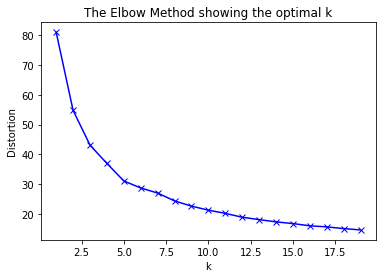

In [15]:
distortions = []
world_K = range(1,20)
for k in world_K:
    kmeanModel = KMeans(n_clusters=k).fit(world_X)
    kmeanModel.fit(world_X)
    distortions.append(sum(np.min(cdist(world_X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / world_X.shape[0])

# Plot the elbow
plt.plot(world_K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Let's look at clustering the gifts at world level, what would it look like?

In [16]:
world_kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 5,  max_iter=400)
world_y_kmeans = world_kmeans.fit_predict(world_X)
world_k=pd.DataFrame(world_y_kmeans, columns=['cluster'])

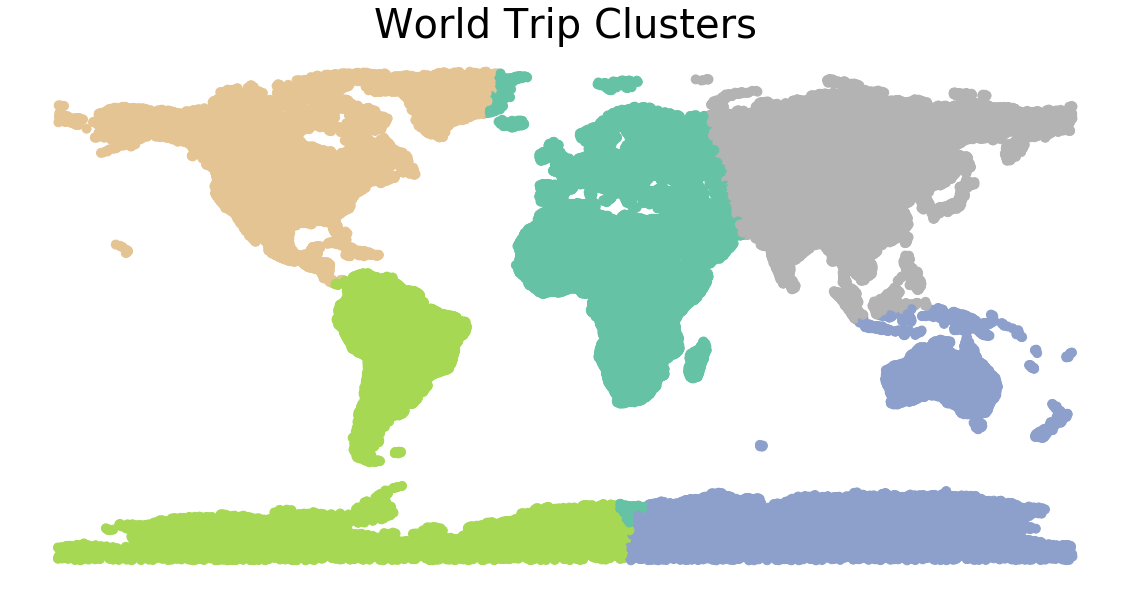

In [17]:
f, ax = plt.subplots(1, figsize=(20,15))
ax.set_title("World Trip Clusters", fontsize=40)
ax.set_axis_off()
world_joined_df = world_gifts_df.reset_index(drop=True).join(world_k)
world_joined_df.plot(column='cluster',cmap='Set2', ax=ax, markersize=80)
plt.show()

Does it make sense to use this? what factors should we include as basis for dividing our coverage besides location?

### Let's assume we need to approach the problem by Country

In [18]:
ph_df = world_gifts_df[world_gifts_df['name']=='Philippines']
ph_df.head()

,GiftId,Weight,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est,pop_children_est
424,425,1.000000,POINT (121.53483 17.72996),147,104256076,Asia,Philippines,PHL,801900.0,28242971
505,506,25.861125,POINT (120.87326 17.55865),147,104256076,Asia,Philippines,PHL,801900.0,28242971
731,732,1.000000,POINT (121.45424 15.84005),147,104256076,Asia,Philippines,PHL,801900.0,28242971
1219,1220,12.454894,POINT (125.43937 6.11672),147,104256076,Asia,Philippines,PHL,801900.0,28242971
1664,1665,1.797168,POINT (120.67870 16.13062),147,104256076,Asia,Philippines,PHL,801900.0,28242971


In [19]:
ph_a=pd.Series(ph_df['geometry'].apply(lambda p: p.x))
ph_b=pd.Series(ph_df['geometry'].apply(lambda p: p.y))
ph_X=np.column_stack((ph_a,ph_b))

pd.DataFrame(ph_X).head()

,0,1
0,121.534829,17.729961
1,120.873265,17.558653
2,121.454238,15.840046
3,125.439367,6.116724
4,120.678699,16.130618


Let's assume a constraint of only 15 visits to PH, how will our cluster look like?

In [20]:
ph_kmeans = KMeans(n_clusters = 15, init = 'k-means++', random_state = 5,  max_iter=400)
ph_y_kmeans = ph_kmeans.fit_predict(ph_X)
ph_k=pd.DataFrame(ph_y_kmeans, columns=['cluster'])

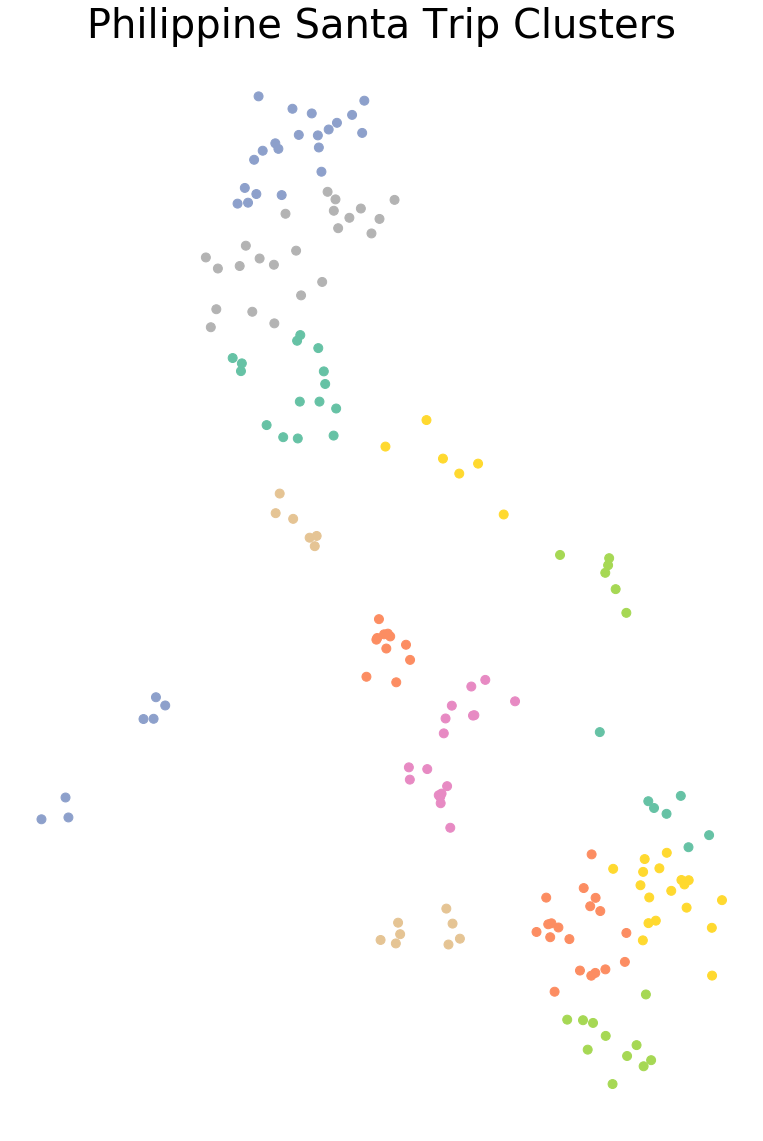

In [21]:
f, ax = plt.subplots(1, figsize=(30,20))
ax.set_title("Philippine Santa Trip Clusters", fontsize=40)
ax.set_axis_off()
joined_df = ph_df.reset_index(drop=True).join(ph_k)
joined_df.plot(column='cluster',cmap='Set2', ax=ax, markersize=80)
plt.show()

How many gifts can we deliver per route visit?

In [22]:
joined_df.groupby("cluster").nunique()['GiftId'].agg(["mean","max","min","median"]) 

mean      11.666667
max       21.000000
min        6.000000
median    11.000000
Name: GiftId, dtype: float64

How much will each trip load look like?

In [23]:
joined_df.groupby("cluster")['Weight'].agg(["sum"]) 

,sum
cluster,
0,90.858998
1,118.393101
2,68.126953
3,230.349435
4,322.796950
5,24.716076
6,257.329813
7,100.469982
8,123.537903


Our average load per trip

In [24]:
joined_df.groupby("cluster")['Weight'].agg(["sum"]).mean()

sum    155.464441
dtype: float64

### Is there a recommended path for us to take per location?
The traveling salesman problem asks the following question: "Given a list of places and the distances between each pair of places, what is the shortest possible route that visits each places exactly once and returns to the origin?"

again, to simplify let's just sample one route

In [25]:
sampled_df = joined_df[joined_df['cluster']==3]
sampled_df

,GiftId,Weight,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est,pop_children_est,cluster
17,7268,27.159631,POINT (124.84400 8.20472),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
32,14851,40.967605,POINT (124.69651 8.32590),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
83,43535,27.140949,POINT (125.20689 7.41054),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
91,48670,1.000000,POINT (124.79040 7.23943),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
92,48699,1.000000,POINT (124.38314 7.83720),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
104,53521,25.702642,POINT (124.65004 7.30322),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
105,53538,1.000000,POINT (124.23167 8.20737),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
111,55704,13.480132,POINT (124.11137 7.78176),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
121,58431,2.926374,POINT (124.96527 7.31802),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3
127,61120,1.000000,POINT (124.77699 8.10050),147,104256076,Asia,Philippines,PHL,801900.0,28242971,3


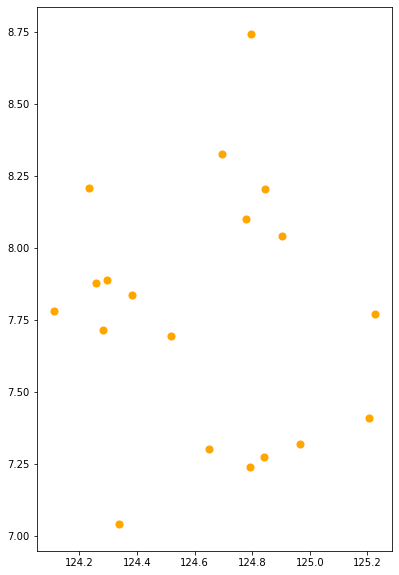

In [26]:
sampled_df.plot(markersize=50,figsize=(15,10),color="orange")

Let's connect all the dots by creating a graph and link them by computing their distance (to simplify, let's use euclidean distance)

### What is a Graph?
In mathematics, and more specifically in graph theory, a graph is a structure amounting to a set of objects in which some pairs of the objects are in some sense "related".
![](https://blog.fastforwardlabs.com/images/editor_uploads/2019-10-25-173715-graph_basics.png)

##### NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

In [27]:
points = range(len(sampled_df))

G = ntx.Graph()

for j in points:
    point = sampled_df.iloc[j].geometry
    G.add_node(point.wkt)
    
for j in points:
    for i in points:
        point1 = sampled_df.iloc[j].geometry
        point2 = sampled_df.iloc[i].geometry
        distance = spy.spatial.distance.euclidean(point1, point2)
        G.add_edge(point1.wkt, point2.wkt, weight=distance)

With our graph G, let's run a function that will return the estimated shortest distance path

In [28]:
tsp = ntx.algorithms.approximation.traveling_salesman_problem
approx_path = tsp(G,cycle=False, weight='weight')

this is what the tsp function estimates to be the salesman's route, in order

In [29]:
approx_path

['POINT (124.231669697 8.207368066080001)',
 'POINT (124.296705622 7.88910406532)',
 'POINT (124.25669394 7.87708436735)',
 'POINT (124.111367911 7.78176085535)',
 'POINT (124.281124281 7.71653302318)',
 'POINT (124.383138202 7.83720197619)',
 'POINT (124.519147617 7.69313759896)',
 'POINT (124.650044456 7.30321655635)',
 'POINT (124.335641962 7.04088541714)',
 'POINT (124.790403849 7.23943466053)',
 'POINT (124.840160879 7.27407878316)',
 'POINT (124.965269668 7.31802304918)',
 'POINT (125.206893779 7.41054065356)',
 'POINT (125.225353616 7.76944410863)',
 'POINT (124.90195425 8.04079272617)',
 'POINT (124.776991085 8.100497648699999)',
 'POINT (124.843997684 8.2047229641)',
 'POINT (124.696511738 8.325903256489999)',
 'POINT (124.794663763 8.74370782754)']

to help us appreciate it better, let's visualize

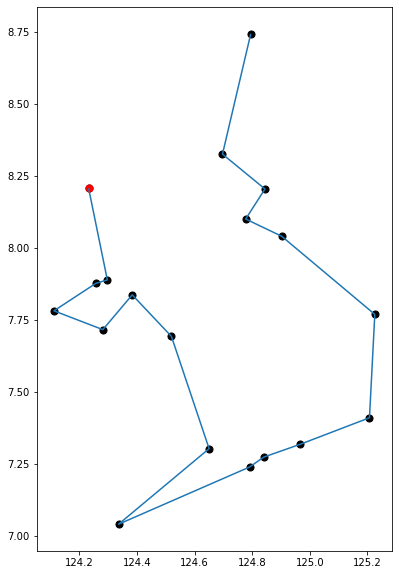

In [30]:
approx_path_line = [shapely.wkt.loads(i) for i in approx_path]
gdf_path = gpd.GeoDataFrame({'geometry':[shapely.geometry.LineString(approx_path_line)]})

fig, ax = plt.subplots(figsize=(15,10))

sampled_df.plot(markersize=50,color="black",ax=ax)
gdf_path.plot(ax=ax)
gpd.GeoSeries([Point(gdf_path.geometry[0].coords[0])]).plot(markersize=50,color="red",ax=ax)

plt.show()

but what does it look like, really

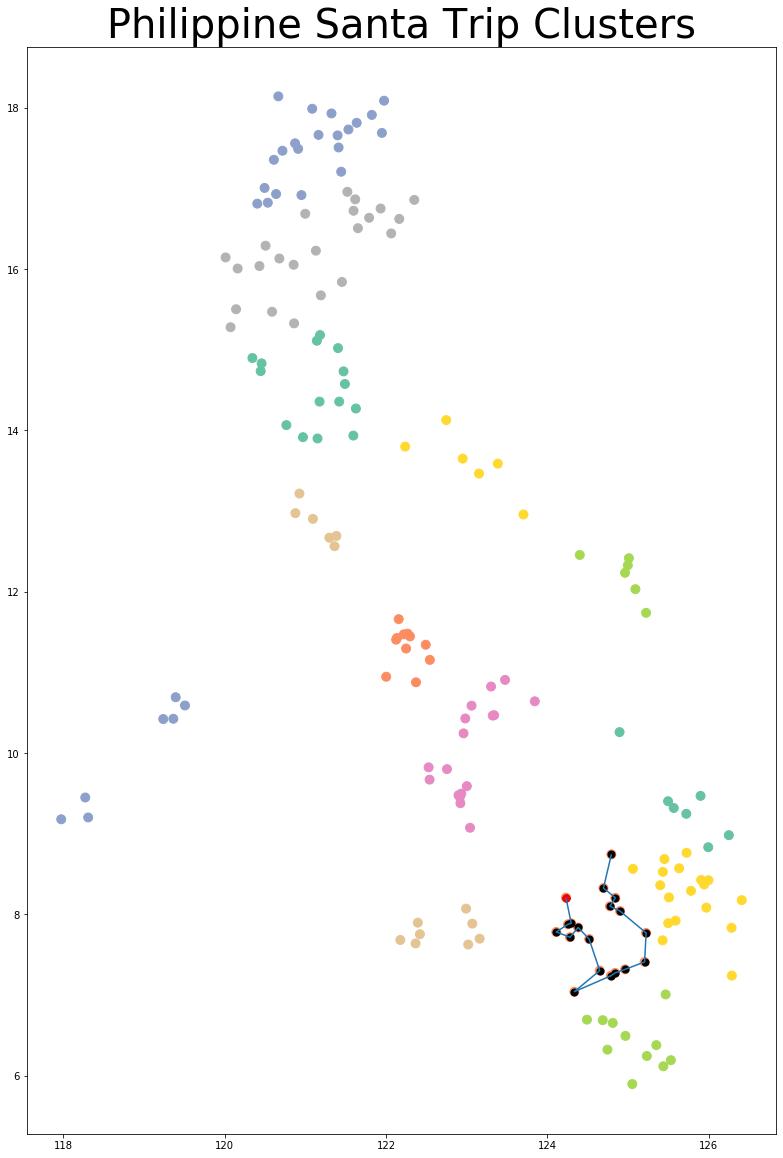

In [31]:
fig, ax = plt.subplots(figsize=(30,20))
ax.set_title("Philippine Santa Trip Clusters", fontsize=40)
joined_df.plot(column='cluster',cmap='Set2', ax=ax, markersize=80)
sampled_df.plot(markersize=50,color="black",ax=ax)
gdf_path.plot(ax=ax)
gpd.GeoSeries([Point(gdf_path.geometry[0].coords[0])]).plot(markersize=50,color="red",ax=ax)
plt.show()

Let's improve our visualization, for fun :) (also, the html file is something we can submit to the elf planners)

##### mplleaflet is a Python library that converts a matplotlib plot into a webpage containing a pannable, zoomable Leaflet map.

In [32]:
mplleaflet.show(fig=fig)

### What other things can we explore to improve our analysis?

- Does weight of the gift have anything to do with location, gdp?
- Can we use gdp or population growth to predict future gift requirements per location?
- How much can the sleigh carry per trip? does lower gift weight affect quality (and therefore allow increased gift load)
- How can we account for rests / weariness of Santa/ Reindeers? what about speed vs time window of delivery?
- What other publicly available data can we get to improve our analysis (is there a naughty vs nice data set out there?)
- What other ways can we do to make sure our data is high quality? 
- What methods and techniques can we use to validate our analysis and ensure best results?